In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfolio.timeseries import perf_stats
import talib
from pyfolio.timeseries import perf_stats

In [2]:
PERIODS = 200
SLOW_MA = 200
FAST_MA = 100
BREAKOUT = 50

In [3]:
results = pd.read_pickle('results_strategy_2a_2008-2018.pickle')
returns = results.returns

In [4]:
equity_curve = (returns + 1).cumprod()
days = len(returns)

In [5]:
equity_curve.tail()

2018-10-25 20:00:00+00:00    6.384478
2018-10-26 20:00:00+00:00    6.157413
2018-10-29 20:00:00+00:00    6.191005
2018-10-30 20:00:00+00:00    6.251151
2018-10-31 20:00:00+00:00    6.372309
Name: returns, dtype: float64

In [6]:
indicators = pd.DataFrame(equity_curve.copy())
indicators.rename(columns={'returns': 'equity'}, inplace=True)
indicators['return'] = indicators['equity'].pct_change()
indicators['std'] = indicators['return'].rolling(PERIODS).std()
indicators['monthly_std'] = indicators['std'] * np.sqrt(21)
indicators['mean_return'] = indicators['return'].rolling(PERIODS).mean()
indicators['mean_monthly_return'] = (indicators['mean_return'] +1)**21 -1
indicators['slow_ma'] = talib.EMA(indicators.equity.values, timeperiod=SLOW_MA)
indicators['fast_ma'] = talib.EMA(indicators.equity.values, timeperiod=FAST_MA)
indicators.tail()

,equity,return,std,monthly_std,mean_return,mean_monthly_return,slow_ma,fast_ma
2018-10-25 20:00:00+00:00,6.384478,-0.001402,0.013247,0.060706,0.000106,0.002227,6.126405,6.252308
2018-10-26 20:00:00+00:00,6.157413,-0.035565,0.013348,0.061168,-0.000207,-0.004329,6.126714,6.250429
2018-10-29 20:00:00+00:00,6.191005,0.005456,0.013089,0.059982,-0.000365,-0.007628,6.127354,6.249252
2018-10-30 20:00:00+00:00,6.251151,0.009715,0.013082,0.059950,-0.000256,-0.005358,6.128585,6.249290
2018-10-31 20:00:00+00:00,6.372309,0.019382,0.013039,0.059750,-0.000281,-0.005891,6.131010,6.251726


In [7]:
in_the_market = True
high_water = 0
results = pd.Series()
for day in range(1, days):
    equity = equity_curve[:day]
    ind = indicators.iloc[:day]
    high_water = max(high_water, equity[-1])
    cutoff = high_water - ((abs(indicators['mean_monthly_return'][day]) + 1 * indicators['monthly_std'][day]) * equity[-1])
    if in_the_market:
        # we're in the market, results = strategy results
        results[equity_curve.index[day]] = indicators['return'][day]
        if equity[-1] < cutoff:
            in_the_market = False
    else:
        results[equity_curve.index[day]] = 0
        if equity[-1] >= equity.rolling(BREAKOUT).max()[-1]:
        #if equity[-1] >= cutoff:
        #if equity[-1] >= equity[-252]:
        #if equity[-1] >= equity.rolling(BREAKOUT).max()[-1] and indicators['fast_ma'][day] > indicators['slow_ma'][day]:
            in_the_market = True

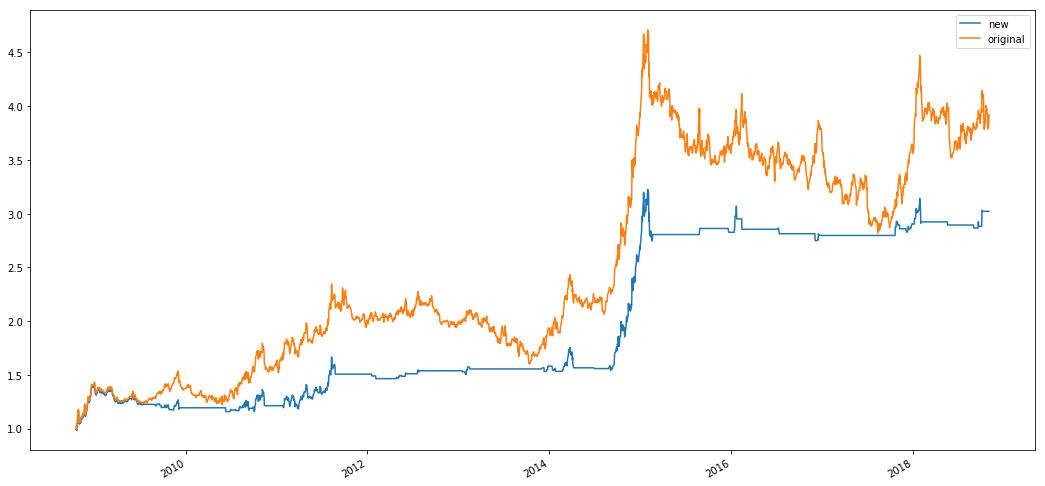

In [8]:
new_returns = pd.DataFrame({'original': indicators['return'][PERIODS:], 
                           'new': results[PERIODS:]})
new_equity_path = (new_returns + 1).cumprod()
new_equity_path.plot(figsize=(18,9));

In [9]:
perf_stats(returns[PERIODS:])

Annual return          0.145768
Cumulative returns     2.918118
Annual volatility      0.225148
Sharpe ratio           0.716991
Calmar ratio           0.363288
Stability              0.840344
Max drawdown          -0.401247
Omega ratio            1.134608
Sortino ratio          1.048639
Skew                   0.082913
Kurtosis               4.409486
Tail ratio             1.035360
Daily value at risk   -0.027725
dtype: float64

In [10]:
perf_stats(results[PERIODS:])

Annual return           0.116524
Cumulative returns      2.021356
Annual volatility       0.150097
Sharpe ratio            0.809289
Calmar ratio            0.645194
Stability               0.865831
Max drawdown           -0.180604
Omega ratio             1.325883
Sortino ratio           1.233457
Skew                    0.573541
Kurtosis               23.620842
Tail ratio              1.466801
Daily value at risk    -0.018428
dtype: float64